# Assignment2

## Notebook made by  

|** Name** | **Student id** | **email**|
|:- |:-|:-|
|Thomas Kamps|10758151|thomas@kamps.email|
|Tom Verburg|10769633|tom_verburg@hotmail.nl|

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. 

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='http://thomaskamps.nl/images/selfie.jpg'/ width=400>

### Note
* **Assignments without the selfies or completely filled in information will not be graded and receive 0 points.**


# Part 1: obtaining information from the web

### RSS parsing

Make a notebook that performs the following steps.

1. Create a script that retrieves all urls of rss feeds from <http://www.volkskrant.nl/rss/feeds/>. Use urllib2 and beautifulsoup for this. Store the urls in a list.
    * **update 2016**
    * As all Dutch sites, Volkskrant asks whether you accept cookies. This makes simple collecting webpages a lot harder. 
    * The code in the code cell below does the trick. 
    * After running this, I could collect further files from Volkskrant without additional cookie hassle.
2. Download all rss feeds and store them on disk.
3. Parse all RSS feeds using `lxml`. Create a list of  dicts with fields "channel", "url", "title", "date" in which you store this information for each item.
4. Compute some statistics about this dict: how many items, how many per channel, are there doubles (items occuring in several channels), etc.
5. Write this list as a csv file, store on disk, and upload to Google fusion tables.
6. Download all articles (once), parse out the text and store as pairs (date,text) in a list.
7. Count per day the number of words, and the number of unique words. Show this in a plot.

In [20]:
import cookielib # Thanks to http://stackoverflow.com/questions/29395407/enabling-cookies-with-urllib
import urllib2
import urllib
import requests
import os
from bs4 import BeautifulSoup
import re
from lxml import etree
from collections import Counter, defaultdict
import pprint
import csv
import pandas as pd
import seaborn as sn
from datetime import date, datetime, time
%matplotlib inline

# Create a script that retrieves all urls of rss feeds from http://www.volkskrant.nl/rss/feeds/. 
# Use urllib2 and beautifulsoup for this. Store the urls in a list.
url = 'http://www.volkskrant.nl/rss/feeds/'

# with urllib2 and handling cookies
cookiejar= cookielib.LWPCookieJar()
opener= urllib2.build_opener( urllib2.HTTPCookieProcessor(cookiejar) )
response=opener.open(url)
html_doc= ' '.join(response.readlines())
 
rsssoup = BeautifulSoup(html_doc, "html5lib")

# test 
list_items = [ref.get('href') for ref in rsssoup.findAll('a') if ref.get('href') and "rss.xml" in ref.get('href')]
len(list_items), list_items[:4]

(33,
 [u'http://www.volkskrant.nl/nieuws/rss.xml',
  u'http://www.volkskrant.nl/nieuws-voorpagina/rss.xml',
  u'http://www.volkskrant.nl/buitenland/rss.xml',
  u'http://www.volkskrant.nl/binnenland/rss.xml'])

In [2]:
# Download all rss feeds and store them on disk.

#make dir for our files
if not os.path.exists("VK-data"):
    os.makedirs("VK-data")

for rssurl in list_items:
    try:
        response = urllib2.urlopen(rssurl)
        #print "Downloaded " + rssurl
        xml = response.read()
        name = rssurl.replace("http://www.volkskrant.nl/", "").replace("/rss.xml", "")
        with open("VK-data/"+name+'.xml', 'w') as f:
            f.write(xml)
    except urllib2.HTTPError:
        print "Oops.. " + rssurl + " not found (404)"

Oops.. http://www.volkskrant.nl/kijkverder/rss.xml not found (404)


In [3]:
# Parse all RSS feeds using lxml. Create a list of dicts with fields "channel", "url", "title", "date"
# in which you store this information for each item.

list_of_items = []
for f in os.listdir('VK-data'):
    if f.endswith(".xml"): 
        doc = etree.parse('VK-data/'+f)
        root = doc.getroot().find('channel')
        channel = root.findtext('title')
        items = [{"title": item.findtext('title'), "url": item.findtext("link"),
                 "date": item.findtext('pubDate'), "channel": channel}
                 for item in root.getiterator('item')]
        list_of_items += items

print list_of_items[:2]

[{'url': 'http://www.volkskrant.nl/wetenschap/belgische-specialisten-willen-nieuw-betalingssysteem~a4459280/', 'date': 'Wed, 08 Feb 2017 01:00:00 GMT', 'channel': 'VK:Archief', 'title': 'Belgische specialisten willen nieuw betalingssysteem'}, {'url': 'http://www.volkskrant.nl/opinie/-oorlogstaal-aanhangers-coalitiepartijen-baart-zorgen~a4459184/', 'date': 'Wed, 08 Feb 2017 01:00:00 GMT', 'channel': 'VK:Archief', 'title': "'Oorlogstaal' aanhangers coalitiepartijen baart zorgen"}]


In [4]:
# Compute some statistics about this dict: how many items, how many per channel, 
# are there doubles (items occuring in several channels), etc.

print "The list of dicts contains " + str(len(list_of_items)) + " items."

count_per_channel = Counter([item['channel'] for item in list_of_items])
print "This dict shows how many items are in each channel: "
pprint.pprint(dict(count_per_channel))

# Use URL's to identify unique items
count_url = Counter([item['url'] for item in list_of_items])
if len(count_url) == len(list_of_items):
    print "No doubles"
else:
    print "There are " + str(len([count for count in count_url if count_url[count] > 1])) + " doubles."

The list of dicts contains 1174 items.
This dict shows how many items are in each channel: 
{'VK:Archief': 40,
 'VK:Beeldende Kunst': 40,
 'VK:Binnenland': 40,
 'VK:Boeken': 40,
 'VK:Buitenland': 40,
 'VK:Cartoons': 14,
 'VK:Economie': 40,
 'VK:Festivals': 40,
 'VK:Film': 40,
 'VK:Foto': 40,
 'VK:Koken & Eten': 40,
 'VK:Magazine': 40,
 'VK:Media': 40,
 'VK:Mode & Mooi': 40,
 'VK:Muziek': 40,
 'VK:Opinie': 40,
 'VK:Politiek': 40,
 'VK:Recensies': 40,
 'VK:Reizen': 40,
 'VK:Sport': 40,
 'VK:Tech': 40,
 'VK:Televisie': 40,
 'VK:Theater': 40,
 'VK:Vonk': 40,
 'VK:Voordeel': 40,
 'VK:Voorpagina': 160,
 'VK:Wetenschap': 40}
There are 200 doubles.


In [5]:
# Write this list as a csv file, store on disk, (and upload to Google fusion tables??).

with open('list_to_csv.csv', 'w') as csvfile:
    names = ['channel', 'url', 'title', 'date']
    writer = csv.DictWriter(csvfile, fieldnames=names)
    writer.writeheader()
    
    for row in list_of_items:
        writer.writerow({key: value.encode('utf-8') for key, value in row.items()})

In [7]:
# Download all articles (once), parse out the text and store as pairs (date,text) in a list.

def download_article(url):
    try:
        response = urllib2.urlopen(url)
        #print "Downloaded " + rssurl
        data = response.read()
        soup = BeautifulSoup(data, "html5lib")
        paragraph = soup.find("p", { "class" : "article__body__paragraph" })
        if paragraph:
            text = paragraph.getText()
            return text
        else:
            print "De artikeltekst is niet gevonden op %s" % (item['url'])
    
    except urllib2.HTTPError:
        print "Oops.. " + rssurl + " not found (404)"
        
list_of_pairs = []

for item in list_of_items:
    text = download_article(item['url'])
    list_of_pairs.append((item['date'], text))

De artikeltekst is niet gevonden op http://www.volkskrant.nl/politiek/wie-kan-met-wie-regeren-bekijk-het-in-deze-coalitiewijzer~a4459611/
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/gummbah~p4368492/?play=true
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/collignon-2~p4368444/
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/bas-van-der-schot~p4368443/
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/sigmund~p4368403/?play=true
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/peter-van-straaten~p3773076/?play=true
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/sigmund~p3761278/?play=true
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/collignon~p3761431/?play=true
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/djanko~p4229228/?play=true
De artikeltekst is niet gevonden op http://www.volkskrant.nl/foto/bas-van-der-schot~p3761404/?play=true


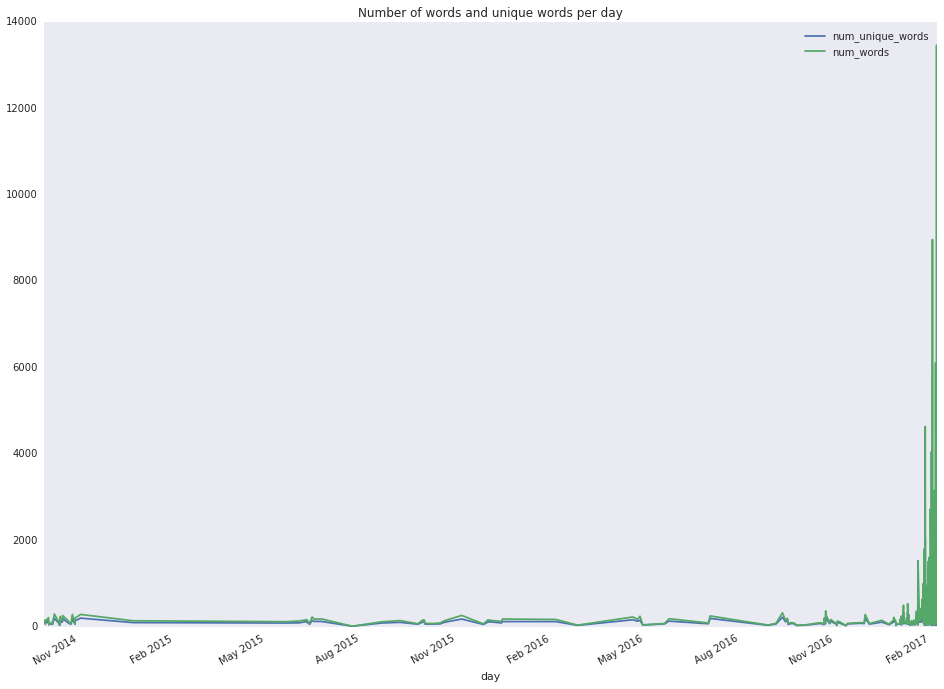

In [28]:
# Count per day the number of words, and the number of unique words. Show this in a plot.

day_dict = defaultdict(str)
for item in list_of_pairs:
    if item[1]:
        day_dict[datetime.strptime(item[0], "%a, %d %b %Y %H:%M:%S %Z")] += item[1]

data = [{"day": key, "num_words": len(value.split(" ")), "num_unique_words": len(set(value.split(" ")))}
        for key, value in day_dict.items()]   

df = pd.DataFrame.from_records(data, index = 'day')
df.plot(figsize=(16, 12), grid=False, title="Number of words and unique words per day")

### JSON parsing

1. Download <http://maartenmarx.nl/teaching/DataScience/NoteBooks/consuming-json-data-from-a-web-service.ipynb>, remove all code blocks, and turn it into a notebook again. 
2. Check that what you did is correct and you did not remove too much using a notebook viewer.
3. Now extract all code from the downloaded notebook, save it to a file, and execute it as a Python script. Does it give errors? Is it syntactically correct?

### PDF parsing

1. Save a wordfile as PDF, open it in Python, extract all text. Describe the differences, if any. Try the same with a two column PDF file from the web. This exercise gets more interesting if you use _difficult_ PDF. Why not try <http://wch.github.io/latexsheet/latexsheet.pdf>?

* Is the word order still as it should be?
* What about the strange characters?

# Part 2 Python recap

Download [PythonRecap2.0.ipynb](PythonRecap2.0.ipynb),  and answer all questions as asked.